# Author recognition based on PSD Dataset
Authors: 


- *Szymon Kasprzycki 193065*
- *Szymon Oryńczak 191722*

# Aim of the project

The main aim of the project consists of the task to create the artificial neural network classifier for the data included in the PSD (Polish Speech Dataset) dataset. The model should be able to determine the author of recording (speech audio) by his voice. It should be trained by backpropagation and the ideal expected classification accuracy at the end should vary around 95%.

# Libraries

Needed packages are:


* Tensorflow
* Numpy
* Matplotlib
* Scipy
* Librosa
* Seaborn

In [ ]:
%pip install tensorflow numpy matplotlib scipy librosa seaborn

And then importing those (and other - default) libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import librosa
import math
import random
import seaborn as sns

Now, it is important to make sure that we have the correct version of tensorflow installed.
It should start with **2.x**

In [3]:
print(f"Tensorflow version: {tf.__version__}")
print(f"Numpy version: {np.__version__}")

Tensorflow version: 2.16.1
Numpy version: 1.26.4


The next crucial step is to check if there is a possibility to use GPU for computations. If it is - it should speed up our computations a little.

In [4]:
is_gpu_available = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU is available" if is_gpu_available else "GPU is not available")

GPU is not available


# Data exploratory research

Secondly, it would be helpful to understand the data. For example, to extract some information about the data that we will be using to train and evaluate our neural network model.

Starting with the basics, the following code checks if the source "data" folder already exists.

In [5]:
if not os.path.exists("data"):
    print("Data directory does not exist. Please create it and put the data files in it.")
else:
    DATA_PATH = os.path.abspath("data")
    print("Full path to data directory:", DATA_PATH)

Full path to data directory: c:\Users\szymo\OneDrive\Dokumenty\Studies\Semester 4\AI\Projekt\RecognizeAuthorNN\data


Next, one can see some statistics and introduction to our source data.

Our source data folder's structure looks like this:

```
[DATA ROOT FOLDER]
    [author_id1 folder]
        {recording_1}.wav
        {recording_2}.wav
        ...
    [author_id2 folder]
        {recording_1}.wav
        {recording_2}.wav
        ...
    ...
[/DATA ROOT FOLDER]
```


In [6]:
authors = [author for author in os.listdir("data") if os.path.isdir(f"data/{author}")]
print(f"Found {len(authors)} authors in the data directory.")

nr_of_recordings = sum([len(os.listdir(f"data/{author}")) for author in authors])
print(f"Found {nr_of_recordings} raw recordings in total.")

Found 24 authors in the data directory.
Found 11891 raw recordings in total.


Function below explores our data directory to prepare list of objects (author_label, filename) ready for access to the preprocessing purpose.

In [7]:
def get_data_names() -> dict:
    """
    Parameters:
    ----------
    None

    Returns:
    ----------
    dict: A dictionary with author names as keys and a list of file names as values.
    
    Description:
    ----------
    This function returns a dictionary with author names as keys and a list of file names as values.
    """
    recordings = []
    for author in os.listdir(DATA_PATH):
        if not os.path.isdir(os.path.join(DATA_PATH, author)):
            continue

        for file in os.listdir(os.path.join(DATA_PATH, author)):
            if file.endswith(".wav"):
                recordings.append((author, os.path.join(DATA_PATH, author, file)))

    return recordings

Function below needs set as a input parameter (author_label, filename). It reads the contents of file and returns basic information as well as the recording data.

In [8]:
def read_audio_data(file_info: set) -> dict:
    """
    Parameters:
    ----------
    file_info: set
        A set containing the author and the file name of the recording.

    Returns:
    ----------
    dict
        A dictionary containing the recording data, the samplerate, the length of the recording, the author and the file name.

    Description:
    ----------
    Reads the audio data from the file and returns it as a dictionary.
    """
    author, file = file_info
    path = os.path.join(DATA_PATH, author, file)
    samplerate, recording_data = scipy.io.wavfile.read(path)
    length = recording_data.shape[0] / samplerate
    return {"data": recording_data, "samplerate": samplerate, "length": length, "author": author, "file": file}

The following function is very simple. It just needs info about file (generated as an output from read_audio_data function) and generates two charts - wave amplitude chart and spectrogram. Both of them allows to initiially visualize the data in two different ways.

In [9]:
def explore_recording(audio_data: dict) -> np.ndarray:
    """
    Parameters:
    ----------
    audio_data : dict
        Dictionary containing the audio data and metadata.

    Returns:
    ----------
    np.ndarray
        The spectrogram of the audio data.

    Description:
    ----------
    Plots the time domain representation of the audio data and its spectrogram.
    """
    time = np.linspace(0., audio_data["length"], audio_data["data"].shape[0])
    plt.plot(time, audio_data["data"], label="signal")
    plt.title("Audio: " + audio_data["file"].split("data")[-1])
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()
    
    spectrogram, freqs, times, plot = plt.specgram(audio_data["data"], Fs=audio_data["samplerate"])
    plt.title("Audio: " + audio_data["file"].split("data")[-1])
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.colorbar(label='Intensity (dB)')
    plt.show()

    return spectrogram

Example usage isprovided below, allows to visualize random raw audio file from the data directory.

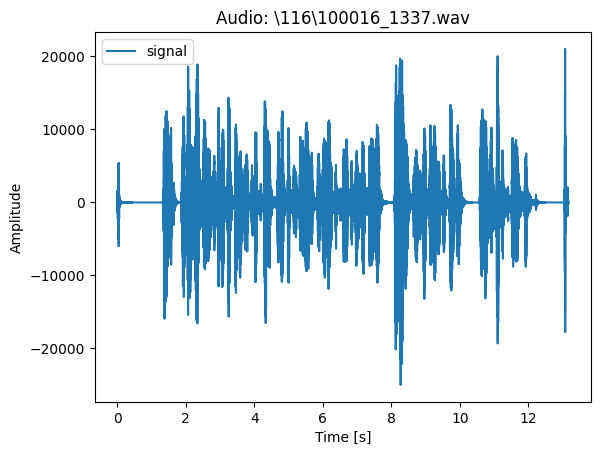

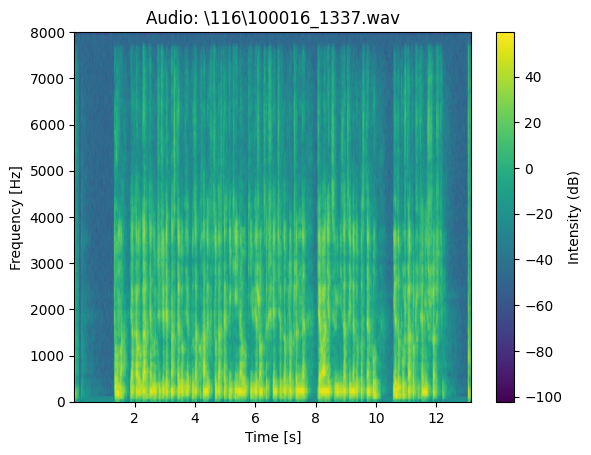

In [10]:
files = get_data_names()
data = read_audio_data(files[np.random.randint(0, len(files))])
spectrogram = explore_recording(data)

# Data preprocessing

The data preprocessing phase should start data preprocessing by splitting the raw recordings to two sets - training set and validation set. <br>
It's crucial to maintain the clear border between those two sets. The effect of interweaving of them may be devastating for the whole project. 

Starting with the code, that will create two sets of samples - training samples and validation samples.<br>

In the below code, the recordings are splitted in such manner that:


* 80% of the data is directed to the training process
* 20% of the data is leaved for the evaluation process

In [11]:
TRAINING_PERCENTAGE = 0.8

np.random.shuffle(files)

num_train = int(len(files) * TRAINING_PERCENTAGE)

train_files = files[:num_train]
validation_files = files[num_train:]

raw_samples = {
    'training': train_files,
    'validation': validation_files
}

print(f"Number of training files: {len(raw_samples['training'])}")
print(f"Number of validation files: {len(raw_samples['validation'])}")

Number of training files: 9512
Number of validation files: 2379


A short look at the example content of the `samples` dictionary.

In [12]:
print('Test:', raw_samples['training'][:5])
print('Validation:', raw_samples['validation'][:5])

Test: [('117', 'c:\\Users\\szymo\\OneDrive\\Dokumenty\\Studies\\Semester 4\\AI\\Projekt\\RecognizeAuthorNN\\data\\117\\100017_1461.wav'), ('105', 'c:\\Users\\szymo\\OneDrive\\Dokumenty\\Studies\\Semester 4\\AI\\Projekt\\RecognizeAuthorNN\\data\\105\\100005_109.wav'), ('121', 'c:\\Users\\szymo\\OneDrive\\Dokumenty\\Studies\\Semester 4\\AI\\Projekt\\RecognizeAuthorNN\\data\\121\\100021_2245.wav'), ('124', 'c:\\Users\\szymo\\OneDrive\\Dokumenty\\Studies\\Semester 4\\AI\\Projekt\\RecognizeAuthorNN\\data\\124\\100024_663.wav'), ('108', 'c:\\Users\\szymo\\OneDrive\\Dokumenty\\Studies\\Semester 4\\AI\\Projekt\\RecognizeAuthorNN\\data\\108\\100008_203.wav')]
Validation: [('115', 'c:\\Users\\szymo\\OneDrive\\Dokumenty\\Studies\\Semester 4\\AI\\Projekt\\RecognizeAuthorNN\\data\\115\\100015_578.wav'), ('116', 'c:\\Users\\szymo\\OneDrive\\Dokumenty\\Studies\\Semester 4\\AI\\Projekt\\RecognizeAuthorNN\\data\\116\\100016_1118.wav'), ('118', 'c:\\Users\\szymo\\OneDrive\\Dokumenty\\Studies\\Semester 4

The next thing is the preprocessing the data in such a way that it will be suitable to train / evaluate our model.

The requirements for that are:


* standardizing the data - providing at least equal length of audio samples
* samples labelling
* logical way of predicting the author of raw recording (of certain, unstandardized length)

As the last two points are not hard to achieve, the first requirement is a little more challenging.

There are around 12k raw ".wav" audio files to process. Their duration range from 0.5 seconds up to more than 30 seconds. The idea is to preprocess them in such a way that we will have ready samples of duration equal to 2 seconds each (for training and evaluating purpose).

But this raises important issue - how would longer/shorter files be handled?
In model training, every training sample is like gold. Every one additional training sample allows us to create a better model. Therefore, cutting random 2 seconds audio fragment from each longer file doesn't satisfy the idea. 

<b>Therefore, following plan was developed:


* For files longer than 2s - split it into equal parts and adjust each length to 2s by copying audio signal to achieve target length.
* For files shorter than 2s - create one sample by copying audio signal to achieve target length.
</b>

Here is the function that will perform this task for a single file:

In [13]:
def normalize_audio_length_wav(file_path: str, out_length: int = 2) -> list[np.ndarray]:
    """
    Parameters
    ----------
    file_path : str
        The path to the .wav file to normalize.
    out_length : int, optional
        The length of the audio data after normalization (in seconds). Default is 2.
    sr : int, optional
        The sampling rate (signal reads per second) of the audio data. Default is 16000.

    Returns
    -------
    list[np.ndarray]
        A list of numpy arrays, each representing a segment of the normalized audio.

    Description
    -----------
    Normalizes the length of the audio data read from the `.wav` file.
    If the audio data is longer than n_samples, it is splitted into equal parts. Then, each part of the audio is padded with the reflection of its signal. 
    If the audio data is shorter than n_samples, it is just extended with the reflection of its signal.
    The function returns a list (np.ndarray) of audio data splitted into equal parts of length out_length (in seconds) or out_length*sr (number of samples).
    """
    _padding_mode = 'reflect' # mode='constant' will change that we will pad with zeros (silence), 'reflect' will reflect the signal

    sr, audio = scipy.io.wavfile.read(file_path)
    _n_samples = out_length * sr

    if len(audio) > _n_samples:
        n_audio = math.ceil(len(audio) / _n_samples)
        audio_segments = np.array_split(audio, n_audio)
        if len(audio_segments[0]) < _n_samples:
            for i in range(len(audio_segments)):
                audio_segments[i] = np.pad(audio_segments[i], (0, _n_samples - len(audio_segments[i])), mode=_padding_mode)
    else:
        audio_segments = [np.pad(audio, (0, _n_samples - len(audio)), mode=_padding_mode)]

    return audio_segments

The function below creates a ./sample directory an stores every normalized file.

Name of each file is as follows: `authorid_numberOfRecording_numberOfSegment.wav`

In [14]:
def save_samples_to_dir(audio_paths: dict, sample_dir: str, sr: int = 16000):
    """
    Parameters
    ----------
    audio_paths : dict
        A dictionary containing the audio data - a paths to the .wav files.
    sample_dir : str
        The directory where the samples will be saved.
    sr : int, optional
        The sample rate of the audio data. Default is 16000.

    Returns
    -------
    None

    Description
    -----------
    This function saves the audio data to the sample directory. The audio data is normalized to 2 seconds by
    functon normalize_audio_length_wav. The samples are saved in the samples_training and samples_validation directories.
    This function overwrite existing files.

    """
    
    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)

    for file_path in audio_paths:
        normalized_segments = normalize_audio_length_wav(file_path[1], out_length=2)
        for i, normalized_file in enumerate(normalized_segments):
            _, file_name = os.path.split(file_path[1])
            base_name = file_name.split('.')[0]
            parts = base_name.split('_')
            new_file_name = f"{file_path[0]}_{parts[1]}_{i}.wav"
            scipy.io.wavfile.write(os.path.join(sample_dir, new_file_name), sr, normalized_file)


# Preprocess the data into samples for training and validation
save_samples_to_dir(raw_samples['training'], os.path.join(os.path.abspath('samples'), 'training'))
save_samples_to_dir(raw_samples['validation'], os.path.join(os.path.abspath('samples'), 'validation'))

And after executing the above block of code, new `samples` directory should be created in our project. It should consist of two subdirectories called `training` and `validation`. Each of them contains preprocessed audio samples that would be used to train/evaluate our model later.

Code below checks the structure of samples:

In [15]:
ready_samples = {'training': [], 'validation': []}

for group in ready_samples.keys():
    for filename in os.listdir(os.path.abspath(f'samples/{group}')):
        author_id = filename.split('_')[0]
        path = os.path.join(os.path.abspath('samples'), group, filename)
        ready_samples[group].append((author_id, path))



print("Example of training tuple:", ready_samples['training'][0])
print("Example of validation tuple:", ready_samples['validation'][0])
print("Number of training samples:", len(ready_samples['training']))
print("Number of validation samples:", len(ready_samples['validation']))

Example of training tuple: ('100', 'c:\\Users\\szymo\\OneDrive\\Dokumenty\\Studies\\Semester 4\\AI\\Projekt\\RecognizeAuthorNN\\samples\\training\\100_2000_0.wav')
Example of validation tuple: ('100', 'c:\\Users\\szymo\\OneDrive\\Dokumenty\\Studies\\Semester 4\\AI\\Projekt\\RecognizeAuthorNN\\samples\\validation\\100_2001_0.wav')
Number of training samples: 33597
Number of validation samples: 8376


And by that, data preprocessing part can be concluded. 
To sum up, raw audio files are normalized into equal parts and saved into sample directory with appropriate labels in file names.

# Input data processing for model

The first thing we do, is defing the function that will take audio sample and process it to the meaningful format which will be fed to our artifical network.

At first, it seemed logical to use audio spectrogram form of the input. However, after some evaluations it seemed better to stick to MFCC (Mel-frequency Cepstral Coefficients).

The decision for MFCCs instead of spectrograms was made because of their ability to capture key features of speech signals more efficiently by representing the short-term power spectrum of sound. MFCC also reduces dimensionality compared to spectrograms. That can improve the model's performance.

The parameters for MFCC are as follows:


* **n_mfcc**: 30 MFCCs are commonly used as they provide a wide representation of the spectral characteristics of the audio signal,

* **n_fft**: A larger value for the number of samples in the Fourier transform window allows for a better frequency resolution in the resulting spectrum. A value of 2048 is often chosen as it balances between optimal frequency resolution and good computational efficiency.

* **hop_length**: This parameter determines the overlap between successive frames in the analysis. A smaller hop length increases temporal resolution, but may lead to increased computational load. A value of 512 strikes provide sufficient overlap for capturing temporal dynamics without excessively increasing computation.

In [16]:
def get_mfcc(audio: np.ndarray, sampling_rate: int) -> np.ndarray:
    """
    Returns the Mel-frequency cepstral coefficients of the audio data
    """
    return librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=30, n_fft=2048, hop_length=512)

Therefore, the data can be processed and saved in the list ready to train the model.

In [17]:
mfcc_train = []
labels_train = []
for i in ready_samples["training"]:
    data, sr = librosa.load(i[1], sr=16000)
    mfcc_train.append(get_mfcc(data, sampling_rate=sr))
    labels_train.append(i[0])


mfcc_val = []
labels_val = []
for i in ready_samples["validation"]:
    data, sr = librosa.load(i[1], sr=16000)
    mfcc_val.append(get_mfcc(data, sampling_rate=sr))
    labels_val.append(i[0])

mfcc_val = np.array(mfcc_val)
mfcc_train = np.array(mfcc_train)

Afterwards, it is important to onehot-encode our samples' labels for the model.

Onehot encoding simply means transforming string labelling into integer labelling and after that - preparing a one dimensional array for each of the samples with encoded label.

In [18]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Assuming labels are string
label_encoder = LabelEncoder()
train_integer_encoded = label_encoder.fit_transform(labels_train)
val_integer_encoded = label_encoder.fit_transform(labels_val)

# One-hot encode the labels
labels_train_encoded = np.array(to_categorical(train_integer_encoded))
labels_val_encoded = np.array(to_categorical(val_integer_encoded))

Short look at the mappings that encoder has created for training labels

In [19]:
print("Encoded_val: label")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")

Encoded_val: label
0: 100
1: 101
2: 102
3: 103
4: 104
5: 105
6: 106
7: 107
8: 108
9: 109
10: 110
11: 111
12: 112
13: 113
14: 114
15: 115
16: 116
17: 117
18: 118
19: 119
20: 121
21: 122
22: 123
23: 124


Now it is crucial to check the shape of the data to make sure that everything is okay by now.

In [20]:
print(labels_train_encoded.shape)
print(mfcc_train.shape)
print(labels_val_encoded.shape)
print(mfcc_val.shape)

(33597, 24)
(33597, 30, 63)
(8376, 24)
(8376, 30, 63)


# Neural network classifier model

Now, the next part is the one with preparing a neural network.

During the research, the Convolutional Neural Network (CNN) seemed promisingly. It is commonly used for audio/image classification tasks. Here's the explanation of each specific layer of implemented network:

1. **Input layer with array size (30,63)**: The input layer's dimensions correspond to the shape of the Mel-frequency cepstral coefficients (MFCCs) extracted from the audio data.

2. **Convolutional layer with 32 filters and a kernel size of 2x2**: The first convolutional layer is designed to extract low-level features from the MFCCs. This layer will learn 32 different low-level features with relatively balanced efficiency and ability to capture patterns, because of the 2x2 kernel.

3. **Max pooling layer with a pool size of 2x2**: The max pooling layer reduces the spatial dimensions of the output from the previous layer, which helps to control overfitting and reduces computational complexity.

4. **Convolutional layer with 64 filters and a kernel size of 2x2**: The second convolutional layer is designed to extract higher-level features from the output of the previous layer. This layer will learn to recognize 64 higher-level features.

5. **Max pooling layer with a pool size of 2x2**: Another max pooling layer further reduces the spatial dimensions of the output from the previous layer.

6. **Flatten layer**: The flatten layer reshapes the 2D output of the previous layer into a 1D vector, so it can be forwarded into the following dense layer.

7. **Dense layer with 1024 neurons and a ReLU activation function**: This dense layer is a fully connected layer that can learn complex patterns in the data.

8. **Dropout layer with a dropout rate of 0.5**: The dropout layer randomly sets a fraction of the input units to 0 during training, which helps to prevent overfitting.

9. **Dense layer with 24 neurons and a softmax activation function**: The final dense layer outputs the probabilities of each class. The softmax activation function ensures that these probabilities sum to 1, so they can be interpreted as the model's confidence scores for each class.

The model is compiled using the Adaptive Moment Estimation (ADAM) optimizer and the categorical crossentropy loss function. 

To sum up, this model is designed to extract features from the MFCCs, and then use them to classify the audio data. Addition of max pooling and dropout layers helps to reduce the risk of model overfitting.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

model = Sequential()

model.add(Input((30, 63, 1)))
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(24, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 29, 62, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 30, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 15, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     5,899,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │        24,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,280 (22.63 MB)

 Trainable params: 5,932,280 (22.63 MB)

 Non-trainable params: 0 (0.00 B)

## Model training and statistics

In [22]:
history = model.fit(mfcc_train, labels_train_encoded, epochs=8, validation_data=(mfcc_val, labels_val_encoded))

Epoch 1/8
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 54s 50ms/step - accuracy: 0.7388 - loss: 4.5908 - val_accuracy: 0.9832 - val_loss: 0.0573
Epoch 2/8
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 54s 51ms/step - accuracy: 0.9684 - loss: 0.0998 - val_accuracy: 0.9869 - val_loss: 0.0468
Epoch 3/8
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 58s 55ms/step - accuracy: 0.9747 - loss: 0.0823 - val_accuracy: 0.9686 - val_loss: 0.1160
Epoch 4/8
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 54s 51ms/step - accuracy: 0.9755 - loss: 0.0821 - val_accuracy: 0.9844 - val_loss: 0.0586
Epoch 5/8
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 56s 53ms/step - accuracy: 0.9816 - loss: 0.0647 - val_accuracy: 0.9755 - val_loss: 0.1115
Epoch 6/8
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 62s 59ms/step - accuracy: 0.9812 - loss: 0.0710 - val_accuracy: 0.9850 - val_loss: 0.0671
Epoch 7/8
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 60s 57ms/step - accuracy: 0.9846 - loss: 0.0601 - val_accuracy: 0.9856 - val_loss: 0.0727
Epoch 8/8
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 60s 57ms/step - accuracy: 0.9840 - loss: 0

Below there is a visualization of some statistics of the training process over time.

Starting with the accuracy, both for training and validation data.

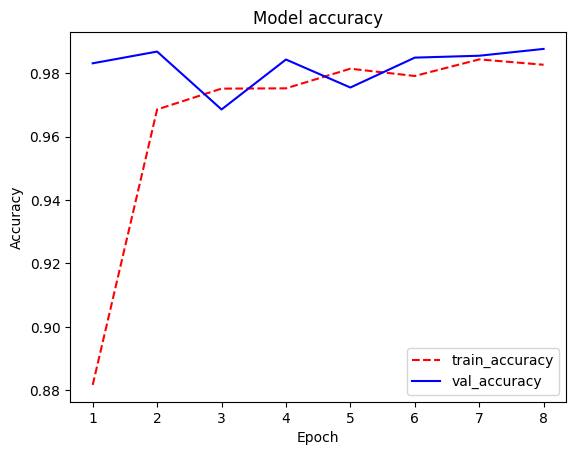

In [23]:
epochs = range(1, len(history.history['accuracy']) + 1)

plt.plot(epochs, history.history['accuracy'], 'r--', label='train_accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b-', label='val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

It looks pretty impressing. After the first epoch, accuracy went to the level of around 87% and then after every epoch it was trending only upwards.

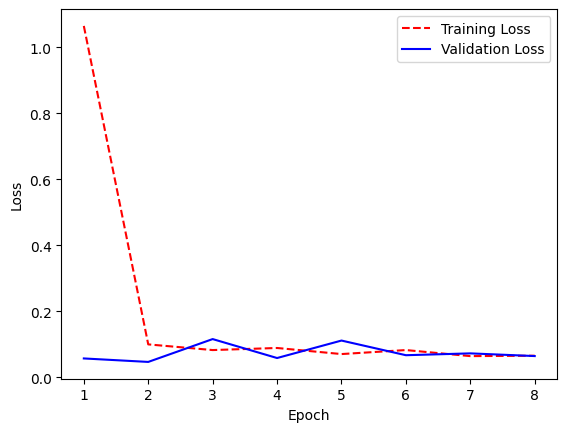

In [24]:
plt.plot(epochs, history.history['loss'], 'r--', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'b-', label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

The loss trend also looks promising. Model quickly minimized the loss function and then the general trend was negative.

Let's look also at the classification report of the validation data. This report shows us the precision of predicting each author.

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

predicted_classes = model.predict(mfcc_val)

predicted_classes_indices = np.argmax(predicted_classes, axis=1)

true_classes_indices = np.argmax(labels_val_encoded, axis=1) if labels_val_encoded.ndim > 1 else labels_val_encoded

print(classification_report(true_classes_indices, predicted_classes_indices))

262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       496
           1       1.00      0.98      0.99       248
           2       0.99      1.00      0.99       321
           3       0.97      0.99      0.98       404
           4       0.95      1.00      0.98       407
           5       0.99      0.98      0.99       360
           6       0.99      0.98      0.98       539
           7       1.00      0.99      0.99       502
           8       0.99      1.00      0.99       374
           9       0.98      0.93      0.96       276
          10       0.99      0.99      0.99       255
          11       0.99      0.99      0.99       344
          12       1.00      1.00      1.00       448
          13       1.00      0.99      1.00       323
          14       0.99      0.99      0.99       303
          15       0.99      1.00      0.99       327
          16       0.99      0.98      0

Also, after that it is also pretty informative to prepare a confusion matrix, which specifically shows us the number of incorrectly classified samples and the distribution of mistakes.

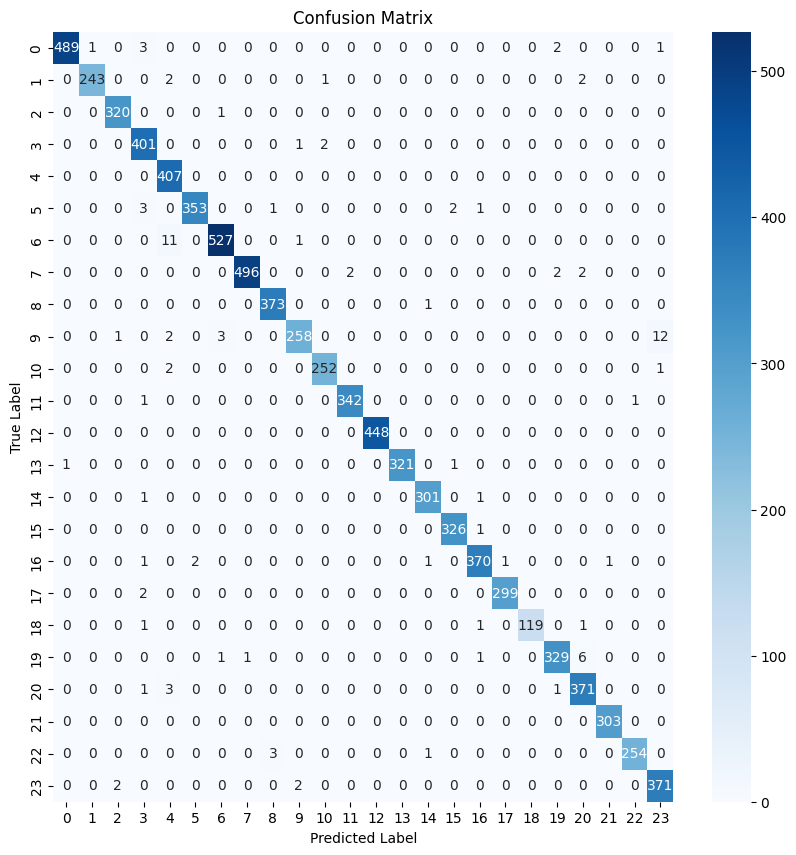

In [26]:
# Generate confusion matrix
cm = confusion_matrix(true_classes_indices, predicted_classes_indices)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Save the model to the file

After evaluating the model, it can finally saved to the file for future predictions or further evaluations.

In [27]:
model.save("psd_predictor.keras")

# Checking the prediction for single random sample (2s length)

The code block prepared below may be used to load the model from file and make a prediction for the random validation unit **loaded to memory**
After few minutes of play with this code, the model shown its good accuracy of classifying those audio samples.

Additional note: Remember to uncomment the 3rd line if you haven't trained the model in current session.

In [28]:
import tensorflow.keras as keras

#model = keras.models.load_model("psd_predictor.keras")

file = ready_samples["validation"][random.randint(0, len(ready_samples["validation"]))]
print("Unit structure:", file)


file_data, file_sr = librosa.load(file[1], sr=16000)

file_mfcc = get_mfcc(file_data, file_sr)
file_mfcc = file_mfcc.reshape((1,30,63))

predictions = model.predict(file_mfcc)

for index, p in enumerate(predictions[0]):
    if index > 19:
        index += 1
    print(f"{index}: {round(p,3)*100}%")

Unit structure: ('102', 'c:\\Users\\szymo\\OneDrive\\Dokumenty\\Studies\\Semester 4\\AI\\Projekt\\RecognizeAuthorNN\\samples\\validation\\102_99_2.wav')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
0: 0.0%
1: 0.0%
2: 100.0%
3: 0.0%
4: 0.0%
5: 0.0%
6: 0.0%
7: 0.0%
8: 0.0%
9: 0.0%
10: 0.0%
11: 0.0%
12: 0.0%
13: 0.0%
14: 0.0%
15: 0.0%
16: 0.0%
17: 0.0%
18: 0.0%
19: 0.0%
21: 0.0%
22: 0.0%
23: 0.0%
24: 0.0%


# Function to make predictions based on the raw full-length audio file

The final coding part of the project is the task to prepare a function that will take file path as an input and will produce a prediction based on the full-length recording.

At the start the pseudo-code for the raw audio prediction was defined as follows:
```
raw_prediciton:
    file read to memory (audio signal, sample rate)

    normalized audio by splitting it into 2s chunks (DO NOT SAVE CHUNKS, LEAVE IN MEMORY)

    for each 2s chunk
        make a prediction
        store the prediction in the out-of-loop-list

    return the most common prediction from the out-of-loop-list
```

And below is the implementation of that function:

In [29]:
from io import BytesIO
import tensorflow.keras as keras

def predict_author(file_path: str) -> None:
    """
    Parameters:
    ----------
    file_path : str
        The path to the .wav file to predict the author of.

    Returns:
    ----------
    int : The predicted author of the .wav file.

    Description:
    ----------
    Predicts the author of the .wav file.
    """
    
    model = keras.models.load_model("psd_predictor.keras")

    file_segments = normalize_audio_length_wav(file_path, out_length=2)

    file_mfcc = []

    file_segments_binary = [BytesIO() for _ in file_segments]

    for i, segment in enumerate(file_segments):
        scipy.io.wavfile.write(file_segments_binary[i], 16000, segment)
        segment_data, segment_sr = librosa.load(file_segments_binary[i], sr=16000)
        file_mfcc.append(get_mfcc(segment_data, sampling_rate=segment_sr))


    file_mfcc = np.array(file_mfcc)

    file_predictions = model.predict(file_mfcc)

    # take the most common prediction
    prediction = np.argmax(np.bincount(np.argmax(file_predictions, axis=1)))

    # sum the percentages of the predictions for each author
    percentages = np.sum(file_predictions, axis=0) / len(file_predictions)

    print(f"Predicted author: {prediction}")

    for index, p in enumerate(percentages):
        if index > 19:
            index += 1
        print(f"{index}: {round(p,3)*100}%")

It works as follows when applied to one of the raw audio files.

In [30]:
file_test = files[np.random.randint(0, len(files))]
print("Real author:", file_test[0])
predict_author(file_test[1])

Real author: 112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predicted author: 12
0: 0.0%
1: 0.0%
2: 0.0%
3: 0.0%
4: 0.0%
5: 0.0%
6: 0.0%
7: 0.0%
8: 0.0%
9: 0.0%
10: 0.0%
11: 0.0%
12: 100.0%
13: 0.0%
14: 0.0%
15: 0.0%
16: 0.0%
17: 0.0%
18: 0.0%
19: 0.0%
21: 0.0%
22: 0.0%
23: 0.0%
24: 0.0%


It is crucial to remember that the encoding of labels to integers is as follows:

| OUT INTEGER CODE | LABEL |
|--------------|-------|
| 0            | 100   |
| 1            | 101   |
| 2            | 102   |
| 3            | 103   |
| 4            | 104   |
| 5            | 105   |
| 6            | 106   |
| 7            | 107   |
| 8            | 108   |
| 9            | 109   |
| 10           | 110   |
| 11           | 111   |
| 12           | 112   |
| 13           | 113   |
| 14           | 114   |
| 15           | 115   |
| 16           | 116   |
| 17           | 117   |
| 18           | 118   |
| 19           | 119   |
| 20           | 121   |
| 21           | 122   |
| 22           | 123   |
| 23           | 124   |
| 24           | 125   |

# Conclusions

## Data quality

The discussion should be started with the quality of data, and ability to provide the maximal standarization of it. The first and most important issue from the dataset is that each audio is most probably recorded with different microphone. This may prevent overfitting, but <u>only</u> in a situation when different authors use the same microphone, but one author uses multiple microphones. However, in this dataset it seems that every author has used his own microphone so that microphone differs for each author, but does not differ withtin recordings of one author. Overall, the quality of each recording is satisfactory—each syllable is clearly audible, the recordings are free of distortions, and the authors' diction and accent are correct and meet the standards of the Polish language.

## Data preparation

The second issue that could be improved in the model preparation is data preprocessing to better generalize the model. We believe that model mainains its accuracy on raw audios from the dataset. However, we are not sure it will work if it got the recording with clear surrondings (filtered out noises) or from a better quality of microphone (this connects with the [Data quality](#Data_quality)).

## Choice of model input data form

We have chosen Mel-frequency cepstral coefficients (MFCCs) over spectrograms due to several reasons. Firstly, MFCCs provide a compact form of an audio signal, reduces the dimensionality of data and makes it easier to process. This is important when dealing with huge datasets or in situation when computational resources are limited. Secondly, MFCCs are more robust to noise in the audio signal. It is crucial here, because our data is usually noisy. Therefore, using MFCCs can lead to better performance in audio classification task.


## Choice of data preprocessing procedure and samples form

During the work on this project, we experimented with a sampling procedure. We've tried different lengths of of model input data into 1 secpnd, 2 seconds, 5 seconds audio segments. Also, we've ran into the issue of loosing some data. We've tried to minimalize the amount of raw signal from dataset audio files. We've tried different methods for the equalization of the samples length, and as a result - during preprocessing phase we are splitting each raw signal into equal segments (of length close to 2 seconds each). Then, we make all segments' length equal to 2 seconds by just reflecting the ending part of its signal until it reaches 2 seconds. Dividing the recordings into 2-second fragments significantly improved the model's effectiveness. The key was selecting the appropriate amounts of training and test data.

## Model quality discussion

Model achieved the accuracy that exceeded our expectations. We assumed the level of 93-95% as the target, however it seems that our decisions on sampling method, on the neural network architecture and the training process provided excellent outcomes. It is far to say that the model is perfect, however as for our conditions we are proud of its accuracy.

## Summary

The project took around 30 working hours to complete. During the project we have expanded our knowledge connected with processing audio files, different audio visualizations, convolutional neural networks and many other issues even not mentioned in this project. It has greatly enhanced our background at neural networks and showed us different possibilities to deal with them.